# **Facial Landmarks Detection**



In this Notebook, I have implemented Facial landmarks(key points) detection system using Convolution Neural networks and image processing techniques. Facial landmark detection is regression kind of task where output is a set of values representing positions in the image rather than one hot encodings that we use generally for classification task.This project uses Keras with TensorFlow in the backend, opencv and dlib libraries. Once we train the landmarks detection model, it will be used for for testing on real time images. For any task of processing facial features on real-time images, first step will be detecing the faces in the image. Face  detection task is achieved by using dlib's implementation. Once faces are detected, we will feed them to the trained model to predict the landmarks. This complete project is seperated into three parts: first part involves loading dataset and prepprocessing it to convert into tensors. Second part is about training and testing CNN model with the data. Third part includes preprocessing real-time image to detect faces and feeding it to trained model to predict landmarks.


## **Part1:**
This part inlcudes collecting data and processing it as required by the model. Collected Kaggle's facial landmark detection dataset that can be found [here](https://Kaggle.com/c/facial-keypoints-detection/data). This dataset has a training file which contains each image with (96 ,96) size and 30 landmarks in csv format. Test file contains only image data and we need to predict 
landmarks for the images. Both files can loaded directly if you are running notebook locally. If you are using Colaboratory, you can load the files from google drive using thier api. Once we load the files, we need to arrange the data into Tensors either **(m,h,w,c) **or **(c,h,w,m)** format as keras api accepts inputs of these formats.


In [8]:
#!pip install pydrive
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from google.colab import files
from sklearn.utils import shuffle

def getFileFromGDrive(train = True):
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Load training files from drive, eed to provide <File_ID> thats has train and test files
  file_list = drive.ListFile({'q': "'1kUOrh7_fUHM1T76e1GGY5KJ2YbvTFyYR' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    print('training/test data: %s' % file1['title'])
  
  file_name = file_list[0]['title'] if train else file_list[1]['title']
  
  if not os.path.exists(file_name):
    train_downloaded = drive.CreateFile({'id': file_list[1]['id']})
    train_downloaded.GetContentFile('test.csv')
    test_downloaded = drive.CreateFile({'id': file_list[0]['id']})
    test_downloaded.GetContentFile('training.csv') 
    print('Successfully loaded the files.')
   # allows you to temporarily load your file in the notebook VM
  
  df = pd.read_csv(file_name)
  return df

def getFileFromLocal():
  uploaded = files.upload()
  df = pd.read_csv("localFilePath")
  return df


def loadData(train=True):
  dFrame = getFileFromGDrive(train) #Change this to load file from local  
   # The Image column has pixel values separated by space convert
   # the values to numpy arrays
  dFrame['Image'] = dFrame['Image'].apply(lambda row: np.fromstring(row, sep=' '))
    
  dFrame = dFrame.dropna()  # drop all rows that have missing values in them
  X = np.vstack(dFrame['Image'].values) / 255.  # scale pixel values to [0, 1]
  X = X.astype(np.float32)
  X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
  
  if train:
    y = dFrame[dFrame.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    X, y = shuffle(X, y, random_state=42)  # shuffle train data
    y = y.astype(np.float32)
  else:
    y = None

  return X, y


def plotData(image, landmarks, figure):
    figure.imshow(np.squeeze(image), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    figure.scatter(landmarks[0::2],landmarks[1::2],marker='o',c='r',s=10)

if __name__ == '__main__':
    loadData(True)
#Load the data once from the drive so that it will be loaded into VM and no need to load
#again. comment out last two lines once downloaded.

training/test data: training.csv
training/test data: test.csv


## **Part2:**

Here, we will create CNN architecture usig Keras sequential model. Created a VGG-16 style architecture with 5 covolution layers and 8 layers in total including dense layers. All convolution layers will have filters with same size and follows power of 2 increaments in the no of filters in the next layer. Intermediate layers will have 'relu' activations. Final layer will have only linear activation as we are not predicting the probabilities of one hot encodings.

Using TensorFlow backend.


training/test data: training.csv
training/test data: test.csv
Input data shape == (2140, 96, 96, 1)
Output shape == (2140, 30)
Sample 1 key points:
 [ 0.4330242  -0.21624877 -0.3466828  -0.3463223   0.25858903 -0.1851669
  0.5810062  -0.1878271  -0.16970447 -0.23996718 -0.5165956  -0.3564843
  0.29375893 -0.24669313  0.74820185 -0.32774875 -0.07298451 -0.2971868
 -0.6224353  -0.51643556 -0.0278047   0.24908654  0.334971    0.3931978
 -0.4643302   0.31000873 -0.06167792  0.52398473 -0.08612007  0.5925943 ]


 CNN Architecture summary_________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)       

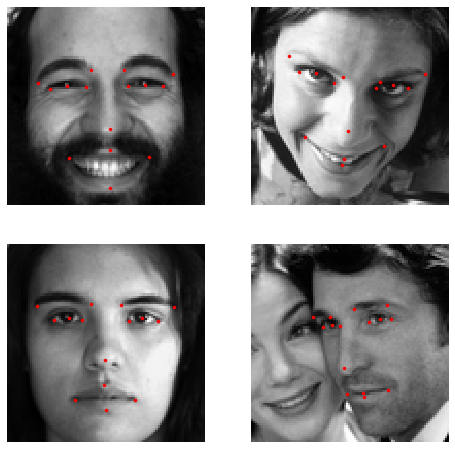

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot  as plt


# Load training set
train_input,train_output = loadData(True)
print("Input data shape == {}".format(train_input.shape))
print("Output shape == {}".format(train_output.shape))
print("Sample 1 key points:\n {}".format(train_output[1]))


# Plot four taining images
%matplotlib inline
fig = plt.figure(figsize=(8,8))
for i in range(4):
    figure = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(train_input[i], train_output[i], figure)
    
#VGG-16 Style Architecture

model  =  Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))

print('\n\n CNN Architecture summary_________________________________________')
model.summary()



---


Now, we will compile the model. Compilation involves specifying optimizer that minimizesthe  loss. Mean square error is choosen for loss function as our final layer outputs are linear activation outputs. If you are choosing mini batch training, need to specify batch size. Specifying  epochs or passes is important as it helps to get a better model by traversing various local optimums. We can also specify checkpointer to save the model after one or more no of passes. Verbose can be used to get logging information while training, parameter can modified to change the level of logging.






In [11]:
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

hist = History()
epochs = 50
#Choose in terms of power of 2
batch_size = 32  
filepath='model_weights.ckpt'

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True, period=5)

#Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(train_input, train_output, validation_split=0.2, callbacks = [checkpointer,hist],
         batch_size=batch_size, epochs=epochs, verbose=1)


#model.save('my_model.h5'),

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0257 - acc: 0.5169 - val_loss: 0.0066 - val_acc: 0.6963
Epoch 2/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0078 - acc: 0.6133 - val_loss: 0.0047 - val_acc: 0.6963
Epoch 3/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0062 - acc: 0.6624 - val_loss: 0.0044 - val_acc: 0.6963
Epoch 4/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0057 - acc: 0.6717 - val_loss: 0.0052 - val_acc: 0.6963
Epoch 5/50
1120/1712 [==================>...........] - ETA: 6s - loss: 0.0056 - acc: 0.6795

1712/1712 [==============================] - 19s 11ms/step - loss: 0.0056 - acc: 0.6746 - val_loss: 0.0043 - val_acc: 0.6963

Epoch 00005: val_loss improved from inf to 0.00434, saving model to model_weights.ckpt
Epoch 6/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0053 - acc: 0.6933 - val_loss: 0.0044 - val_acc: 0.6963
Epoch 7/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0052 - acc: 0.6957 - val_loss: 0.0043 - val_acc: 0.6963
Epoch 8/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0048 - acc: 0.6968 - val_loss: 0.0040 - val_acc: 0.6963
Epoch 9/50
1088/1712 [==================>...........] - ETA: 6s - loss: 0.0045 - acc: 0.6829

1712/1712 [==============================] - 19s 11ms/step - loss: 0.0044 - acc: 0.6910 - val_loss: 0.0036 - val_acc: 0.6963
Epoch 10/50
1696/1712 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.6981
Epoch 00010: val_loss improved from 0.00434 to 0.00300, saving model to model_weights.ckpt
Epoch 11/50
1712/1712 [==============================] - 20s 11ms/step - loss: 0.0032 - acc: 0.6992 - val_loss: 0.0024 - val_acc: 0.7056
Epoch 12/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0028 - acc: 0.7050 - val_loss: 0.0021 - val_acc: 0.7126
Epoch 13/50
1600/1712 [===========================>..] - ETA: 1s - loss: 0.0025 - acc: 0.7119

1712/1712 [==============================] - 20s 12ms/step - loss: 0.0025 - acc: 0.7144 - val_loss: 0.0019 - val_acc: 0.7336
Epoch 14/50
1712/1712 [==============================] - 20s 12ms/step - loss: 0.0023 - acc: 0.7220 - val_loss: 0.0018 - val_acc: 0.7313
Epoch 15/50
1712/1712 [==============================] - 20s 11ms/step - loss: 0.0021 - acc: 0.7290 - val_loss: 0.0019 - val_acc: 0.7360

Epoch 00015: val_loss improved from 0.00300 to 0.00189, saving model to model_weights.ckpt
Epoch 16/50
1712/1712 [==============================] - 20s 11ms/step - loss: 0.0020 - acc: 0.7447 - val_loss: 0.0017 - val_acc: 0.7734
Epoch 17/50
1536/1712 [=========================>....] - ETA: 1s - loss: 0.0018 - acc: 0.7435

1712/1712 [==============================] - 19s 11ms/step - loss: 0.0018 - acc: 0.7412 - val_loss: 0.0015 - val_acc: 0.7593
Epoch 18/50
1712/1712 [==============================] - 20s 11ms/step - loss: 0.0018 - acc: 0.7366 - val_loss: 0.0015 - val_acc: 0.7617
Epoch 19/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0017 - acc: 0.7629 - val_loss: 0.0015 - val_acc: 0.7874
Epoch 20/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0016 - acc: 0.7664 - val_loss: 0.0015 - val_acc: 0.7804

Epoch 00020: val_loss improved from 0.00189 to 0.00149, saving model to model_weights.ckpt
Epoch 21/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0015 - acc: 0.7734 - val_loss: 0.0014 - val_acc: 0.7640
Epoch 22/50


1712/1712 [==============================] - 19s 11ms/step - loss: 0.0015 - acc: 0.7605 - val_loss: 0.0017 - val_acc: 0.7850
Epoch 23/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0014 - acc: 0.7874 - val_loss: 0.0013 - val_acc: 0.7827
Epoch 24/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0014 - acc: 0.7915 - val_loss: 0.0013 - val_acc: 0.7710
Epoch 25/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0013 - acc: 0.7938 - val_loss: 0.0013 - val_acc: 0.7897

Epoch 00025: val_loss improved from 0.00149 to 0.00126, saving model to model_weights.ckpt
Epoch 26/50
1600/1712 [===========================>..] - ETA: 1s - loss: 0.0012 - acc: 0.7931

1712/1712 [==============================] - 19s 11ms/step - loss: 0.0012 - acc: 0.7944 - val_loss: 0.0012 - val_acc: 0.7804
Epoch 27/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0012 - acc: 0.7886 - val_loss: 0.0012 - val_acc: 0.8014
Epoch 28/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0011 - acc: 0.7827 - val_loss: 0.0011 - val_acc: 0.8061
Epoch 29/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0011 - acc: 0.7850 - val_loss: 0.0011 - val_acc: 0.7874
Epoch 30/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0011 - acc: 0.7996 - val_loss: 0.0011 - val_acc: 0.7944

Epoch 00030: val_loss improved from 0.00126 to 0.00113, saving model to model_weights.ckpt
Epoch 31/50
 192/1712 [==>...........................] - ETA: 16s - loss: 0.0010 - acc: 0.8177

1712/1712 [==============================] - 19s 11ms/step - loss: 0.0010 - acc: 0.8078 - val_loss: 0.0011 - val_acc: 0.8037
Epoch 32/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0010 - acc: 0.8119 - val_loss: 0.0011 - val_acc: 0.7874
Epoch 33/50
1712/1712 [==============================] - 19s 11ms/step - loss: 0.0010 - acc: 0.8078 - val_loss: 0.0011 - val_acc: 0.8037
Epoch 34/50
1712/1712 [==============================] - 20s 11ms/step - loss: 9.6906e-04 - acc: 0.8067 - val_loss: 0.0011 - val_acc: 0.7897
Epoch 35/50
1712/1712 [==============================] - 19s 11ms/step - loss: 9.6116e-04 - acc: 0.8090 - val_loss: 0.0013 - val_acc: 0.8037

Epoch 00035: val_loss did not improve from 0.00113
Epoch 36/50
  32/1712 [..............................] - ETA: 17s - loss: 0.0011 - acc: 0.7812

1712/1712 [==============================] - 19s 11ms/step - loss: 9.7609e-04 - acc: 0.8072 - val_loss: 0.0011 - val_acc: 0.7991
Epoch 37/50
1712/1712 [==============================] - 19s 11ms/step - loss: 8.8039e-04 - acc: 0.8072 - val_loss: 0.0014 - val_acc: 0.7874
Epoch 38/50
1712/1712 [==============================] - 19s 11ms/step - loss: 8.8272e-04 - acc: 0.8265 - val_loss: 0.0013 - val_acc: 0.8131
Epoch 39/50
1712/1712 [==============================] - 19s 11ms/step - loss: 9.0525e-04 - acc: 0.8067 - val_loss: 0.0011 - val_acc: 0.7944
Epoch 40/50
1664/1712 [============================>.] - ETA: 0s - loss: 8.7049e-04 - acc: 0.8155

1712/1712 [==============================] - 19s 11ms/step - loss: 8.6989e-04 - acc: 0.8160 - val_loss: 0.0011 - val_acc: 0.8061

Epoch 00040: val_loss improved from 0.00113 to 0.00106, saving model to model_weights.ckpt
Epoch 41/50
1712/1712 [==============================] - 19s 11ms/step - loss: 8.1385e-04 - acc: 0.8254 - val_loss: 0.0011 - val_acc: 0.7827
Epoch 42/50
1712/1712 [==============================] - 19s 11ms/step - loss: 8.5830e-04 - acc: 0.8148 - val_loss: 0.0010 - val_acc: 0.7874
Epoch 43/50
1712/1712 [==============================] - 20s 11ms/step - loss: 8.0124e-04 - acc: 0.8306 - val_loss: 0.0010 - val_acc: 0.8131
Epoch 44/50
 992/1712 [================>.............] - ETA: 7s - loss: 7.8149e-04 - acc: 0.8387

1712/1712 [==============================] - 19s 11ms/step - loss: 8.1373e-04 - acc: 0.8417 - val_loss: 0.0011 - val_acc: 0.8037
Epoch 45/50
1712/1712 [==============================] - 19s 11ms/step - loss: 7.5905e-04 - acc: 0.8318 - val_loss: 0.0011 - val_acc: 0.8037

Epoch 00045: val_loss did not improve from 0.00106
Epoch 46/50
1712/1712 [==============================] - 19s 11ms/step - loss: 7.4914e-04 - acc: 0.8411 - val_loss: 9.9354e-04 - val_acc: 0.7991
Epoch 47/50
1712/1712 [==============================] - 19s 11ms/step - loss: 7.2618e-04 - acc: 0.8335 - val_loss: 0.0011 - val_acc: 0.7967
Epoch 48/50
1376/1712 [=======================>......] - ETA: 3s - loss: 7.2496e-04 - acc: 0.8488

1712/1712 [==============================] - 19s 11ms/step - loss: 7.3686e-04 - acc: 0.8452 - val_loss: 0.0010 - val_acc: 0.7991
Epoch 49/50
1712/1712 [==============================] - 19s 11ms/step - loss: 7.1281e-04 - acc: 0.8347 - val_loss: 9.8429e-04 - val_acc: 0.7664
Epoch 50/50
1712/1712 [==============================] - 19s 11ms/step - loss: 7.5432e-04 - acc: 0.8464 - val_loss: 0.0010 - val_acc: 0.8061

Epoch 00050: val_loss improved from 0.00106 to 0.00101, saving model to model_weights.ckpt




---



Here, we will test our trained model on unseen data. Test data provided by Kaggle is loaded here and converted them into tensors. Once we feed tensors to the trained model, model will predict the landmarks. These landmarks are scaled back to original image dimensions to scatter on the image. Predictions can be seen in the following figure.

training/test data: training.csv
training/test data: test.csv
Test data shape == (1783, 96, 96, 1)


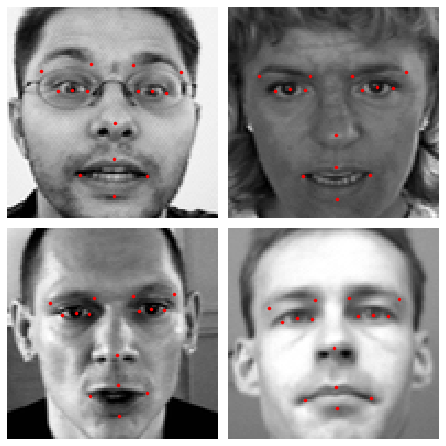

In [12]:

# get the checkpoint file to load the weights
model.load_weights(filepath)

# Load testing set
X_test, _ = loadData(False)

print("Test data shape == {}".format(X_test.shape))

predictions = model.predict(X_test)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(X_test[i], predictions[i], ax)

In [0]:
#!apt update
#!apt install -y cmake
#!pip install dlib

Note: Before proceding to next part, we need to install above packages of dlib and opencv if not installed beforehand.

## **Part3**

Here, we will test our model with real time images. To test with real time images, first we need to detect faces in the frames. Although, Face detection and landmark detection task can be carried out together using CN Networks, it involves implementation of complex algorithm like YOLO algorithm. Since, we have open sourced face detection libraries like opencv and dlib, we can use them to detect faces. Dlib's implementation works better than opencv's since it uses HOG Features trained with SVM . Opencv uses Adaboost alogorithm trained Haar-like features and it is shown to have low accuracy on various faces datasets like FDDB. 

In [0]:
import cv2
import dlib

import argparse
import time
from google.colab import files
import numpy as np

#load the test image 
files.upload()
image = cv2.imread("test_2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(1, 1, 1, xticks=[], yticks=[])

detector = dlib.get_frontal_face_detector()
rects = detector(image, 1)

for (i,rect) in enumerate(rects):
  cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 0, 255), 2);
  detection = image[rect.top():rect.bottom(), rect.left():rect.right()]
  print(rect)
  detect_copy = np.copy(detection)
  test_image = cv2.cvtColor(detection, cv2.COLOR_RGB2GRAY)
  test_image = cv2.resize(test_image,(96,96))/255
  test_image = np.expand_dims(test_image, axis=0)
  test_image = np.expand_dims(test_image, axis=3)
  predictions =  np.squeeze(model.predict(test_image))
  y_scale = (detection.shape[0])/96
  x_scale = (detection.shape[1])/96
  ax1.scatter(((predictions[0::2] * 48 + 48)*x_scale)+rect.left()+1,((predictions[1::2]*48+48)*y_scale)+rect.top()-6, 
                   marker='o', c='r', s=8)
  
ax1.imshow(image)

